Using device: cuda


/home/vicente/Github/NIH-Chest-X-ray-Dataset/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['No Finding'] will be ignored
  warnings.warn(


Validation DataLoader is ready


/tmp/ipykernel_6540/3904927565.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Model loaded and set to evaluation mode


100%|██████████| 707/707 [00:30<00:00, 23.13it/s]


=== Overall Evaluation Metrics ===
Accuracy: 0.1196
Precision (Macro): 0.1937
Recall (Macro): 0.4722
F1-Score (Macro): 0.2564
Precision (Micro): 0.1988
Recall (Micro): 0.6662
F1-Score (Micro): 0.3063

Classification Report
                    precision    recall  f1-score   support

       Atelectasis       0.19      0.80      0.30      2364
      Cardiomegaly       0.24      0.45      0.31       548
          Effusion       0.27      0.85      0.41      2701
      Infiltration       0.19      0.93      0.32      4048
              Mass       0.21      0.39      0.28      1222
            Nodule       0.17      0.31      0.22      1270
         Pneumonia       0.06      0.03      0.04       275
      Pneumothorax       0.22      0.63      0.33      1165
     Consolidation       0.12      0.49      0.19       918
             Edema       0.12      0.55      0.19       419
         Emphysema       0.36      0.51      0.42       647
          Fibrosis       0.12      0.08      0.10       

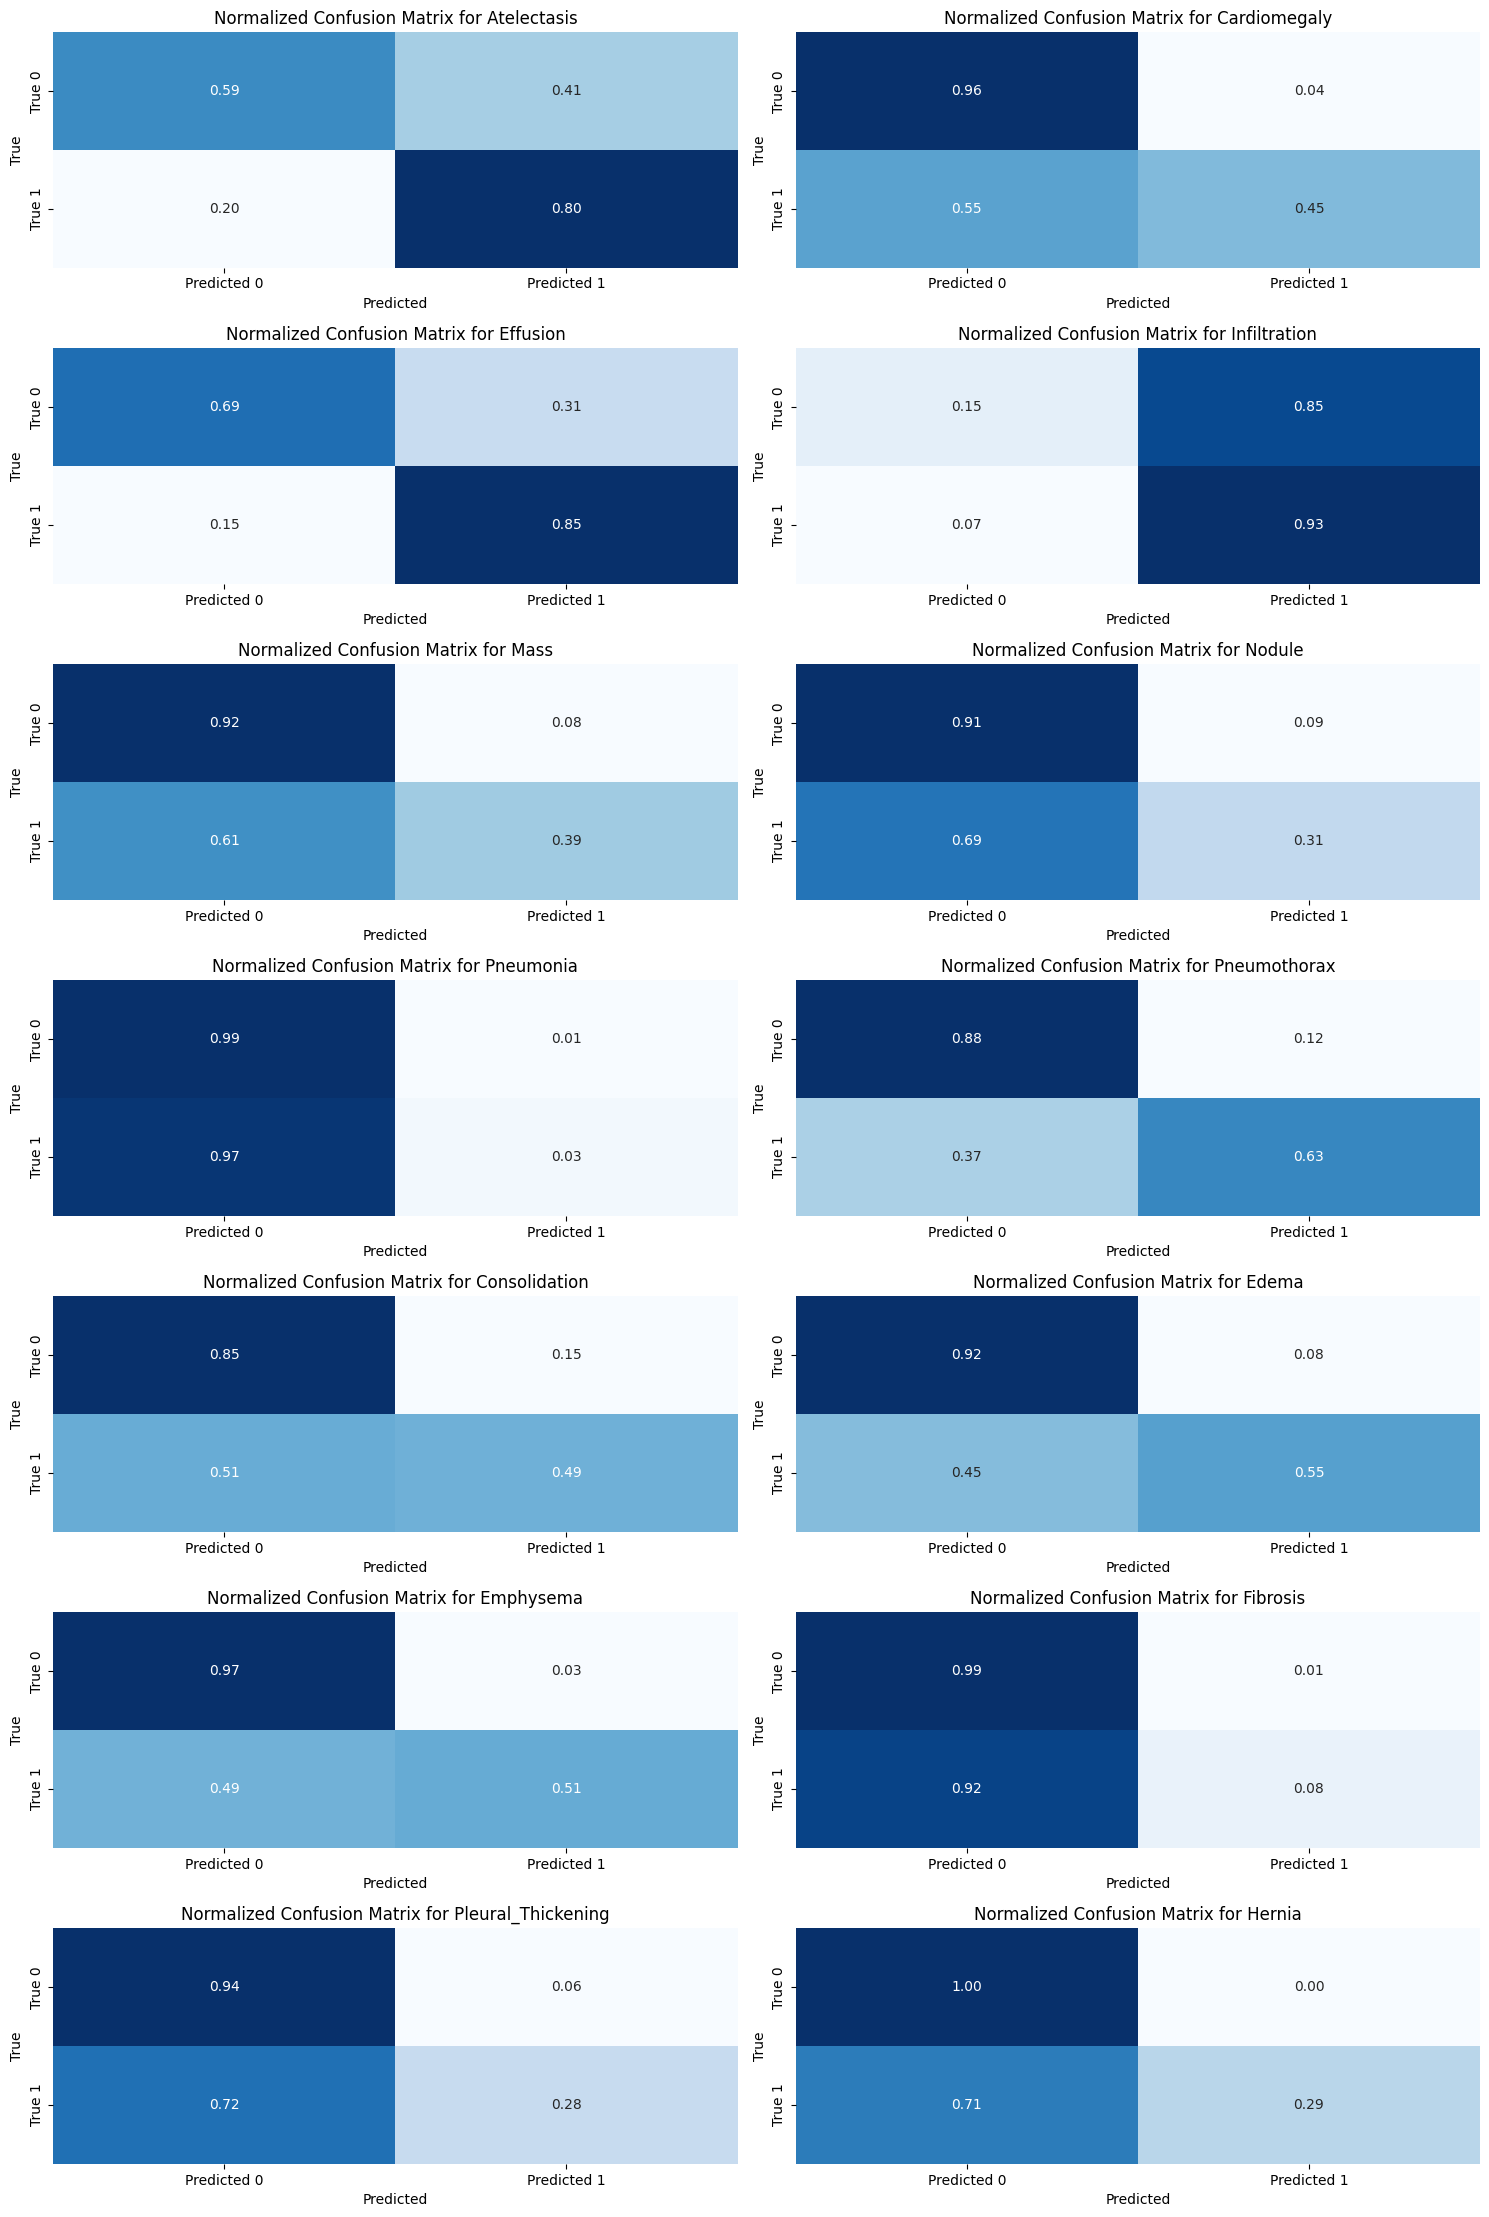

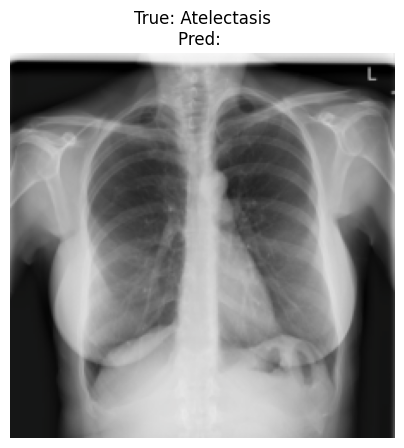

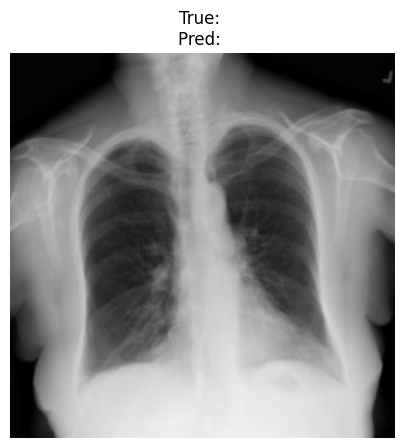

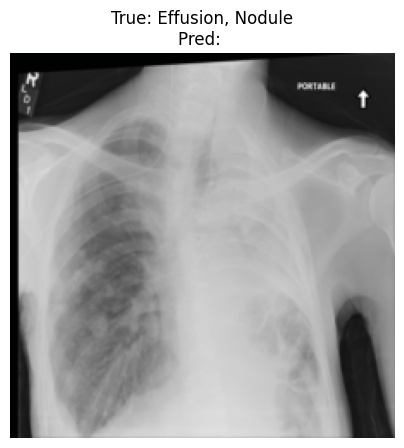

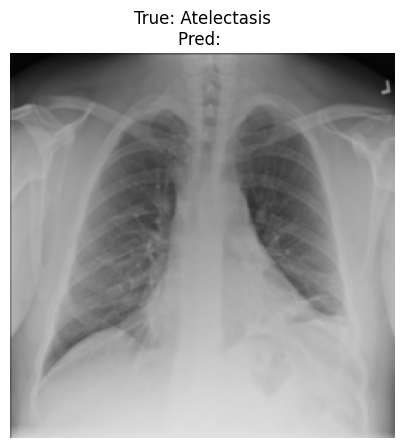

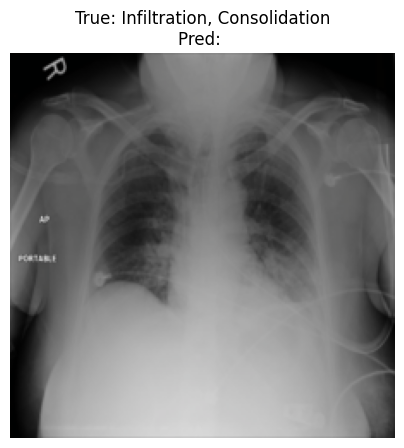

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    multilabel_confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from tqdm import tqdm
from dataset import ChestXRayDataset
from CNN import create_model
%matplotlib inline

classes = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration",
    "Mass", "Nodule", "Pneumonia", "Pneumothorax",
    "Consolidation", "Edema", "Emphysema", "Fibrosis",
    "Pleural_Thickening", "Hernia"
]

NUM_CLASSES = 14
IMAGE_SIZE = 224  
BATCH_SIZE = 32

device = torch.device('cuda')
print(f'Using device: {device}')

mlb = MultiLabelBinarizer(classes=classes)

DATA_CSV = "Data/Data_Entry_2017_v2020.csv" 
IMAGES_DIR = "Data/images/" 

images = pd.read_csv(DATA_CSV)

images.columns = [
    "Image Index", "Finding Labels", "Follow-up #", "Patient ID",
    "Patient Age", "Patient Gender", "View Position",
    "OriginalImageWidth", "OriginalImageHeight",
    "OriginalImagePixelSpacing_x", "OriginalImagePixelSpacing_y"
]

images['Finding Labels'] = images['Finding Labels'].str.split('|')
y = mlb.fit_transform(images['Finding Labels'])

train_patients, val_patients = train_test_split(
    images['Patient ID'].unique(),
    test_size=0.2,
    random_state=1  
)

train_df = images[images['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = images[images['Patient ID'].isin(val_patients)].reset_index(drop=True)

train_y = mlb.transform(train_df['Finding Labels'])
val_y = mlb.transform(val_df['Finding Labels'])


val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_dataset = ChestXRayDataset(val_df, val_y, IMAGES_DIR, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)  

print("Validation DataLoader is ready")

model = create_model(num_classes=NUM_CLASSES)
model_path = "best_model_224.pth"  
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

print("Model loaded and set to evaluation mode")

all_preds = []
all_labels = []

with torch.no_grad():
    for images_batch, labels_batch in tqdm(val_loader):
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        
        outputs = model(images_batch)
        
        preds = outputs.cpu().numpy()
        true_labels = labels_batch.cpu().numpy()
        
        all_preds.append(preds)
        all_labels.append(true_labels)


all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)
all_probs = 1 / (1 + np.exp(-all_preds))


# we did a very low threshold here due to poor model performance
threshold = 0.1  
all_preds_binary = (all_probs > threshold).astype(int)

# the overall accuracy followed by the macro and micro averaged
accuracy = accuracy_score(all_labels, all_preds_binary)
precision_macro = precision_score(all_labels, all_preds_binary, average='macro', zero_division=0)
recall_macro = recall_score(all_labels, all_preds_binary, average='macro', zero_division=0)
f1_macro = f1_score(all_labels, all_preds_binary, average='macro', zero_division=0)

precision_micro = precision_score(all_labels, all_preds_binary, average='micro', zero_division=0)
recall_micro = recall_score(all_labels, all_preds_binary, average='micro', zero_division=0)
f1_micro = f1_score(all_labels, all_preds_binary, average='micro', zero_division=0)

print("=== Overall Evaluation Metrics ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"Precision (Micro): {precision_micro:.4f}")
print(f"Recall (Micro): {recall_micro:.4f}")
print(f"F1-Score (Micro): {f1_micro:.4f}")

report = classification_report(all_labels, all_preds_binary, target_names=classes, zero_division=0)
print("\nClassification Report")
print(report)

mcm = multilabel_confusion_matrix(all_labels, all_preds_binary)

plt.figure(figsize=(15, 25))
for i, class_name in enumerate(classes):
    cm = mcm[i].astype('float') / mcm[i].sum(axis=1)[:, np.newaxis] 
    plt.subplot(8, 2, i+1)
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title(f'Normalized Confusion Matrix for {class_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.show()


num_samples = 5
indices = random.sample(range(len(val_dataset)), num_samples)

means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

inv_means = []
for m, s in zip(means, stds):
    inv_means.append(-m / s)

inv_stds = []
for s in stds:
    inv_stds.append(1 / s)

inv_normalize = transforms.Normalize(mean=inv_means, std=inv_stds)


for idx in indices:
    image, label = val_dataset[idx]
    
    inv_img = inv_normalize(image).permute(1, 2, 0).numpy().clip(0, 1)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(inv_img)
    plt.axis('off')
    
    true_labels = []
    for i, val in enumerate(label):
        if val == 1:
            true_labels.append(classes[i])

    image_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(image_tensor).cpu().numpy().squeeze()
    
    pred_labels = []
    for i, val in enumerate(pred > threshold):
        if val:
            pred_labels.append(classes[i])
    
    plt.title(f"True: {', '.join(true_labels)}\nPred: {', '.join(pred_labels)}")
    plt.show()